### Table of Contents

1. [Installation - Importing data, modules and libs](#installation)
2. [Project Motivation](#motivation)
3. [File Descriptions](#files)
4. [Results](#results)
5. [Licensing, Authors, and Acknowledgements](#licensing)

## Installation <a name="installation"></a>

### Importing modules, libs and csv files

In [281]:
import matplotlib.dates as mdates

In [354]:
from collections import defaultdict

In [329]:
import matplotlib.ticker as mtick

In [324]:
import matplotlib

In [322]:
import matplotlib.pyplot as plt

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from pandas.tseries.offsets import MonthEnd
import seaborn as sns
%matplotlib inline
#AirBnB Boston
calendar_b = pd.read_csv('calendar.csv')
reviews_b = pd.read_csv('reviews.csv')
listings_b = pd.read_csv('listings.csv')
#AirBnB Seattle
calendar_s = pd.read_csv('calendar-2.csv')
reviews_s = pd.read_csv('reviews-2.csv')
listings_s = pd.read_csv('listings-2.csv')

## Project Motivation <a name="motivation"></a>

For this project, I was interestested in using Airbnb Open Data, Boston and Seattle in particular
to better understand:

1. How much AirBnB earning in certain time frames and areas?
2. Compare rates between the two cities? 
and try to understand if there is anything about the properties that helps you predict price. 
3. Find negative and positive reviews based on text? 

## File Descriptions <a name="file"></a>

### Boston datasets

#### Calendar

In [163]:
calendar_b.shape

(1308890, 4)

In [170]:
calendar_b.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [204]:
calendar_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [205]:
#let's check how much rows with na prices
calendar_b['price'].isna().sum()

665853

In [206]:
#let's drop rows with na prices
calendar_b_clean=calendar_b.dropna(subset=['price'])

In [207]:
#changing data type for column 'date' to datetime
calendar_b_clean.loc[:,'date']=pd.to_datetime(calendar_b_clean.loc[:,'date'])

In [208]:
#changing data type for column 'price' to float
calendar_b_clean.loc[:,'price']=calendar_b_clean.loc[:,'price'].replace('[\$,]', '', regex=True).astype(float)

In [210]:
#check
calendar_b_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 365 to 1308879
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  643037 non-null  int64         
 1   date        643037 non-null  datetime64[ns]
 2   available   643037 non-null  object        
 3   price       643037 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 24.5+ MB


### Reviews

In [215]:
reviews_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [211]:
reviews_b.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [216]:
#let's drop rows with na comments
reviews_b_clean=reviews_b.dropna(subset=['comments'])

In [218]:
#changing data type for column 'date' to datetime 
reviews_b_clean.loc[:,'date']=pd.to_datetime(reviews_b_clean.loc[:,'date'])

In [220]:
reviews_b_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68222 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     68222 non-null  int64         
 1   id             68222 non-null  int64         
 2   date           68222 non-null  datetime64[ns]
 3   reviewer_id    68222 non-null  int64         
 4   reviewer_name  68222 non-null  object        
 5   comments       68222 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.6+ MB


In [356]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [368]:
possible_vals = ["great", "good", 
                 "awesome", "nice", "bad",
                 "awful", "ok", "terrible","sweet","very bad"]

def clean_and_plot(df, title='Reviews', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    comments = df['comments'].value_counts().reset_index()
    comments.rename(columns={'index': 'comments', 'comments': 'count'}, inplace=True)
    comments_df = total_count(comments, 'comments', 'count', possible_vals)

    comments_df.set_index('comments', inplace=True)
    if plot:
        (comments_df/comments_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_comments_df = comments_df/comments_df.sum()
    return props_comments_df

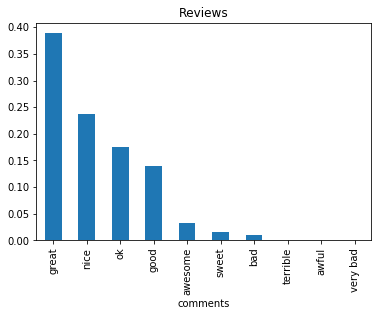

,count
comments,
great,0.388619
nice,0.236652
ok,0.176031
good,0.139490
awesome,0.032382
sweet,0.014887
bad,0.009638
terrible,0.001397
awful,0.000629


In [369]:
clean_and_plot(reviews_b_clean)

### Listings

In [229]:
listings_b_clean=listings_b[listings_b.columns[listings_b.count()>=3500]]

In [231]:
listings_b_clean=listings_b_clean.dropna()

In [372]:
listings_b_clean.loc[:,'price']=listings_b_clean.loc[:,'price'].replace('[\$,]', '', regex=True).astype(float)

In [376]:
listings_b_clean.loc[:,'extra_people']=listings_b_clean.loc[:,'extra_people'].replace('[\$,]', '', regex=True).astype(float)

In [384]:
listings_model_cols=listings_b_clean[['property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','extra_people','availability_30','availability_60','availability_90','availability_365','number_of_reviews','price']]

In [383]:
cat_df = listings_model_cols.select_dtypes(include=['object'])

In [381]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    dummies=pd.get_dummies(df[cat_cols],prefix_sep='_',dummy_na=dummy_na)
    df=df.drop(cat_cols,axis=1)
    df=pd.concat([df, dummies], axis=1)
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [385]:
cat_cols_lst = cat_df.columns

In [387]:
df_new = create_dummy_df(listings_b_clean, cat_cols_lst, dummy_na=False) #Use your newly created function

In [391]:
print(listings_b_clean.shape)

(3492, 59)


In [388]:
print(df_new.shape)

(3492, 74)


In [392]:
df_new.head()

,id,listing_url,scrape_id,last_scraped,name,description,experiences_offered,picture_url,host_id,host_url,...,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",none,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,...,0,0,0,0,0,0,0,0,0,1
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,none,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,...,0,0,0,0,1,0,0,0,0,1
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...",none,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,https://www.airbnb.com/users/show/16701,...,0,0,0,0,1,0,0,0,0,1
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...",none,https://a1.muscache.com/im/pictures/97154760/8...,15396970,https://www.airbnb.com/users/show/15396970,...,0,0,0,0,1,0,0,0,0,1
5,12386020,https://www.airbnb.com/rooms/12386020,20160906204935,2016-09-07,Private Bedroom + Great Coffee,Super comfy bedroom plus your own bathroom in ...,none,https://a2.muscache.com/im/pictures/930c78b2-f...,64200298,https://www.airbnb.com/users/show/64200298,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
#Split into explanatory and response variables
X = df_new[['CareerSatisfaction', 'HoursPerWeek', 'JobSatisfaction', 'StackOverflowSatisfaction','number_of_reviews']]
y = df_new['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

In [373]:
listings_b_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3492 entries, 0 to 3584
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3492 non-null   int64  
 1   listing_url                       3492 non-null   object 
 2   scrape_id                         3492 non-null   int64  
 3   last_scraped                      3492 non-null   object 
 4   name                              3492 non-null   object 
 5   description                       3492 non-null   object 
 6   experiences_offered               3492 non-null   object 
 7   picture_url                       3492 non-null   object 
 8   host_id                           3492 non-null   int64  
 9   host_url                          3492 non-null   object 
 10  host_name                         3492 non-null   object 
 11  host_since                        3492 non-null   object 
 12  host_l

In [234]:
left=calendar_b_clean

left.loc[:,'id']=left.loc[:,'listing_id']

right=listings_b_clean.loc[:,['id','city','state']]

In [235]:
result =  pd.merge(left, right[['id','city','state']], how='left', on=['id'])

In [236]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 0 to 643036
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  643037 non-null  int64         
 1   date        643037 non-null  datetime64[ns]
 2   available   643037 non-null  object        
 3   price       643037 non-null  float64       
 4   id          643037 non-null  int64         
 5   city        625282 non-null  object        
 6   state       625282 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 39.2+ MB


In [237]:
result_clean=result.dropna(subset=['city'])

In [238]:
result_clean.loc[:,'month']= pd.to_datetime(result_clean['date'], format="%Y%m") + MonthEnd(1)

In [239]:
result_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625282 entries, 0 to 643036
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  625282 non-null  int64         
 1   date        625282 non-null  datetime64[ns]
 2   available   625282 non-null  object        
 3   price       625282 non-null  float64       
 4   id          625282 non-null  int64         
 5   city        625282 non-null  object        
 6   state       625282 non-null  object        
 7   month       625282 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 42.9+ MB


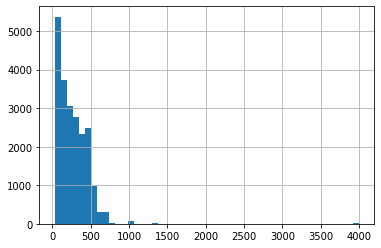

In [338]:
result_clean[(result_clean['city']=='Boston')&(result_clean['month']=='2016-09-30')]['price'].hist(bins=50);

In [334]:
result_clean[result_clean['city']=='Boston'].groupby(['month'])['price'].median()

month
2016-09-30    225.0
2016-10-31    198.0
2016-11-30    170.0
2016-12-31    160.0
2017-01-31    152.0
2017-02-28    150.0
2017-03-31    150.0
2017-04-30    155.0
2017-05-31    150.0
2017-06-30    152.0
2017-07-31    155.0
2017-08-31    155.0
2017-09-30    150.0
Name: price, dtype: float64

In [344]:
boston_median_rate_dynamic=result_clean[result_clean['city']=='Boston'].groupby(['month'])['price'].median()

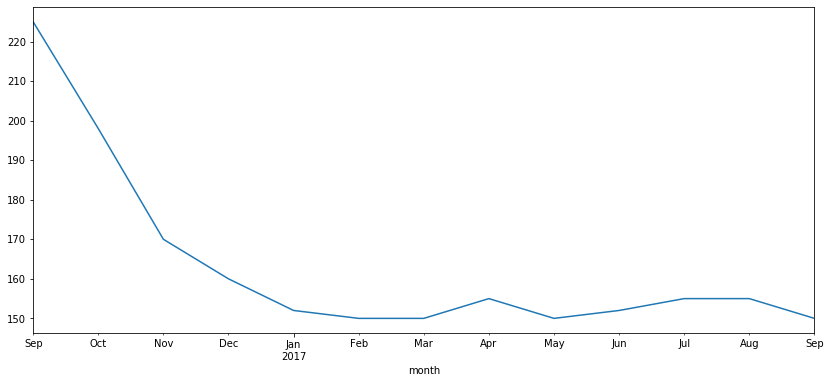

In [342]:
ax=boston_median_rate_dynamic.plot(figsize=[14,6])
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [345]:
boston_earnings_dynamic=result_clean[result_clean['city']=='Boston'].groupby(['month'])['price'].sum()

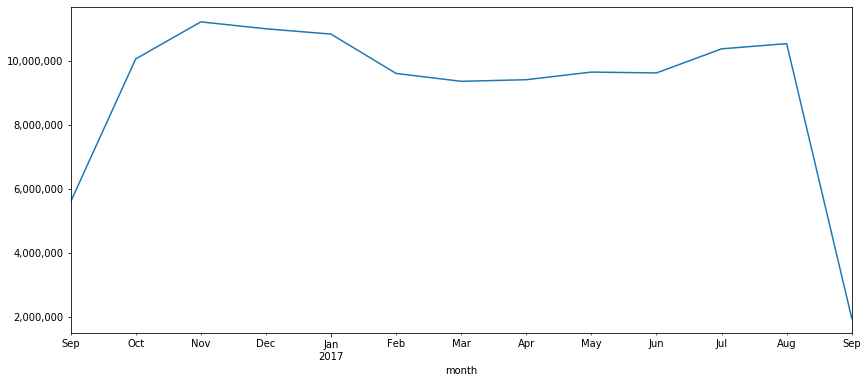

In [347]:
ax1=boston_earnings_dynamic.plot(figsize=[14,6])
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))